# Red out model generation

This document outlines the model generation for the automated red out script. We use the model generated in this script to annotated redded-out frames in videos. We also do some metric validation in this script

In [141]:
# Save Model Using Pickle
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score

import numpy as np
import matplotlib.pyplot as plt

import pickle
import re
import datetime
from os.path import isfile, join
import csv

In [2]:
%load_ext rpy2.ipython

In [44]:
%%R

library(tidyverse)
library(ggplot2)
library(magrittr)

R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:purrr’:

    set_names


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract




In [4]:
# We need these variables later
test_size = 0.1
seed = 7

## Inter-rater agreement

We are interested in comparing how different users determine frames as being redded out or not.

In [25]:
# Load the annotated frames by GGK and DJP
ggk_red_out = pd.read_csv('~/Downloads/Red-Out - GGK Frames.tsv', delimiter='\t')
ggk_red_out['Source'] = 'GGK'

djp_red_out = pd.read_csv('~/Downloads/Red-Out - DJP Frames.tsv', delimiter='\t')
djp_red_out['Notes'] = ''
djp_red_out['Source'] = 'DJP'

In [35]:
red_outs_combined = pd.concat([ggk_red_out, djp_red_out], ignore_index=True, sort =False)
red_outs_combined = red_outs_combined.fillna('')

In [27]:
# GGK's frames
red_frames_ggk_ranges = [(ggk_red_out['Start Frame'][i], ggk_red_out['End Frame'][i]) for i in range(ggk_red_out.shape[0])]
red_frames_ggk_all = []

for rr in red_frames_ggk_ranges:
    red_frames_ggk_all = red_frames_ggk_all + [i for i in range(rr[0], rr[1]+1)]

# DJP's frames    
red_frames_djp_ranges = [(djp_red_out['Start Frame'][i], djp_red_out['End Frame'][i]) for i in range(djp_red_out.shape[0])]
red_frames_djp_all = []
    
for rr in red_frames_djp_ranges:
    red_frames_djp_all = red_frames_djp_all + [i for i in range(rr[0], rr[1]+1)]

ggk_frames_red_labels = [1 if i in red_frames_ggk_all else 0 for i in range(10000)]
djp_frames_red_labels = [1 if i in red_frames_djp_all  else 0 for i in range(10000)]

In [28]:
overlapping_red_out = list(set(red_frames_ggk_all) & set(red_frames_djp_all))
overlapping_non_red = list(
    (set([i for i in range(10000+1)]) - set(red_frames_ggk_all)) &
    (set([i for i in range(10000+1)]) - set(red_frames_djp_all))
)

We can use the cohen kappa score to measure the inter-rater agreement. In brief, this is a statistical measure of rater agreement between 0 and 1. Complete agreement would be a value of 1.

In [68]:
kappa_score = round(cohen_kappa_score(ggk_frames_red_labels, djp_frames_red_labels), 4)

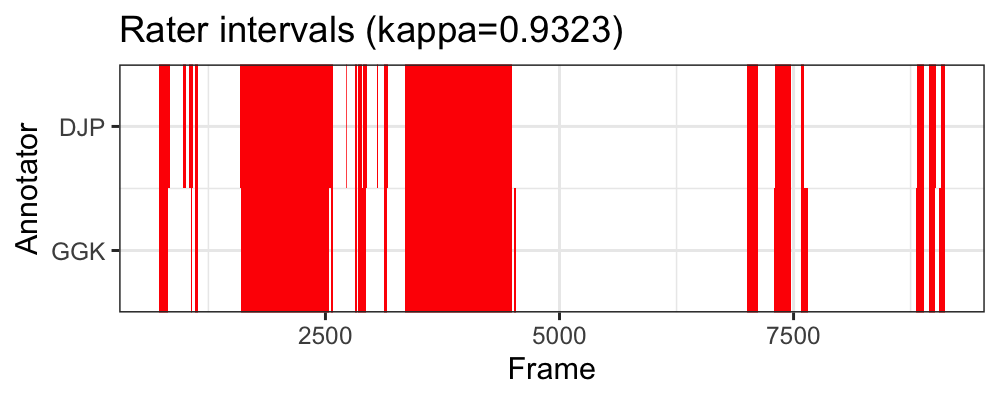

In [72]:
%%R -i red_outs_combined,kappa_score -w 5 -h 2 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

levels_order <- c('GGK', 'DJP')

red_outs_combined_plot <- red_outs_combined %>%
    magrittr::set_colnames(gsub('\\.', ' ', colnames(.))) %>%
    mutate(Source=factor(Source, levels=levels_order)) %>%
    mutate(y=as.integer(Source))

plot_title <- paste0('Rater intervals (kappa=',  kappa_score, ')')

redding_out_overall <- ggplot(red_outs_combined_plot) +
    geom_rect(aes(xmin=`Start Frame`, xmax=`End Frame`, ymin=y-0.5, ymax=y+0.5), fill='red') +
    scale_y_continuous(expand = c(0,0), breaks=seq(1, length(levels_order)), labels=levels_order) +
    xlab('Frame') + ylab('Annotator') +
    ggtitle(plot_title) +
    theme_bw()

redding_out_overall

Load metrics dataset run on the first 10000 frames of ParkCity2019-170211-ch1_video_01 to assess model metrics.

There are several ways we could approach model training. For our ground-truth, we will use frames that both GGK and DJP labelled 'red.'

In [75]:
generated_metrics_testing = pd.read_csv('~/Documents/USC/USC_docs/ml/surgical-training-project/file-preprocessing/output-test/redout-testing-notebook.tsv', delimiter='\t')

generated_metrics_testing['index'] = [int(re.sub('frame_0+', '', re.sub('\\.jpeg', '', f))) for f in generated_metrics_testing['frame']]
generated_metrics_testing['GGK'] = [1 if i in red_frames_ggk_all else 0 for i in generated_metrics_testing['index']]
generated_metrics_testing['DJP'] = [1 if i in red_frames_djp_all else 0 for i in generated_metrics_testing['index']]


In [76]:
# The column we will use for the prediction - for now will be if both annotators agree on this being a red out.
generated_metrics_testing['ANNOTATED_REDOUT_CALL'] = [1 if (i in red_frames_djp_all) and (i in red_frames_ggk_all) else 0 for i in generated_metrics_testing['index']]

In [124]:
# Here, select the metrics that we want to use for the prediction task
columns_to_ignore = ['frame', 'index', 'GGK', 'DJP', 'ANNOTATED_REDOUT_CALL', 'channel_0', 'channel_1', 'channel_2']
columns_to_use_for_model = [i for i in range(len(generated_metrics_testing.columns)) if generated_metrics_testing.columns[i] not in columns_to_ignore]
ggk_col_index = [j for j in range(len(generated_metrics_testing.columns)) if generated_metrics_testing.columns[j] == 'GGK']

In [125]:
# To get a list of the prediction columns we are using
# [generated_metrics_testing.columns[i] for i in columns_to_use_for_model]

In [126]:
metrics_as_array = generated_metrics_testing.values
X = metrics_as_array[:,columns_to_use_for_model]
Y = generated_metrics_testing['ANNOTATED_REDOUT_CALL'].values

Index(['range_x0-360y0-640z0', 'range_x0-360y640-1280z0',
       'range_x0-360y1280-1920z0', 'range_x360-720y0-640z0',
       'range_x360-720y640-1280z0', 'range_x360-720y1280-1920z0',
       'range_x720-1080y0-640z0', 'range_x720-1080y640-1280z0',
       'range_x720-1080y1280-1920z0', 'range_x0-360y0-640z1',
       'range_x0-360y640-1280z1', 'range_x0-360y1280-1920z1',
       'range_x360-720y0-640z1', 'range_x360-720y640-1280z1',
       'range_x360-720y1280-1920z1', 'range_x720-1080y0-640z1',
       'range_x720-1080y640-1280z1', 'range_x720-1080y1280-1920z1',
       'range_x0-360y0-640z2', 'range_x0-360y640-1280z2',
       'range_x0-360y1280-1920z2', 'range_x360-720y0-640z2',
       'range_x360-720y640-1280z2', 'range_x360-720y1280-1920z2',
       'range_x720-1080y0-640z2', 'range_x720-1080y640-1280z2',
       'range_x720-1080y1280-1920z2'],
      dtype='object')

In [128]:
# Compare predicting RJP vs. GGK's labels
model_data = [{'name':'GGK'}, {'name':'DJP'}, {'name': 'ANNOTATED_REDOUT_CALL'}]

for mi in range(len(model_data)):
    m = model_data[mi]
    y_m = generated_metrics_testing[m['name']]
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y_m, test_size=test_size, random_state=seed)
    
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, Y_train)
    
    result = model.score(X_test, Y_test)
    roc=roc_auc_score(Y_test, model.predict_proba(X_test)[:,1])
    
    model_data[mi]['model'] = model
    model_data[mi]['accuracy'] = result
    model_data[mi]['AUROC'] = round(roc, 4)

model_data

[{'name': 'GGK',
  'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=10000,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False),
  'accuracy': 0.973,
  'AUROC': 0.9935},
 {'name': 'DJP',
  'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=10000,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False),
  'accuracy': 0.962,
  'AUROC': 0.9866},
 {'name': 'ANNOTATED_REDOUT_CALL',
  'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter

## Model generation

In this section, we will start generating models and evaluating how those models perform

In [129]:
# Generate data frame of
models_data = {
    'column_name': generated_metrics_testing.columns[columns_to_use_for_model],
    'GGK_pred': model_data[0]['model'].coef_[0],
    'DJP_pred': model_data[1]['model'].coef_[0],
    'ANNOTATED_REDOUT_CALL': model_data[2]['model'].coef_[0]
}
models_data_df = pd.DataFrame(data=models_data)

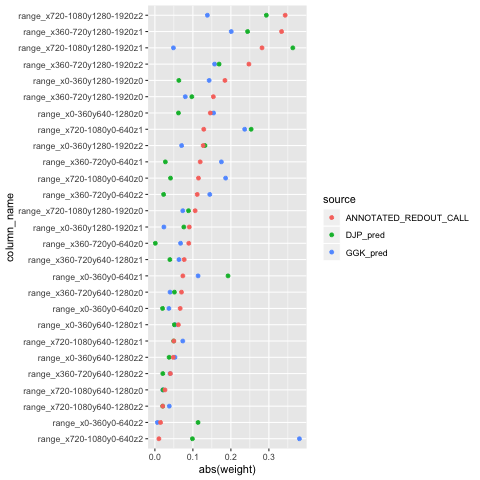

In [130]:
%%R -i models_data_df

models_data_df_data <- models_data_df %>%
    gather(source, weight, -column_name)

col_order <- models_data_df_data %>%
#     group_by(column_name) %>%
#     dplyr::summarize(m=mean(abs(weight))) %>%
#     arrange(m) %$%
    filter(source=='ANNOTATED_REDOUT_CALL') %>%
    arrange(abs(weight)) %$%
    column_name

models_data_df_data %<>% mutate(column_name=factor(column_name, levels=col_order))

ggplot(models_data_df_data, aes(source, column_name, fill=abs(weight))) +
    geom_tile() +
    scale_fill_gradient2(high='red', low='blue', mid='white', midpoint=0)

ggplot(models_data_df_data, aes(abs(weight), column_name, color=source)) +
    geom_point()

In [144]:
data_source = '/Users/guillaumekugener/Documents/USC/USC_docs/ml/surgical-training-project/data/'
current_date = datetime.datetime.today()
model_output_file_name = str(current_date.year) + str(current_date.month) + str(current_date.day) + '-red-out-model.sav'
filename = join(data_source, model_output_file_name)
pickle.dump(model_data[2]['model'], open(filename, 'wb'))

# Save the column names used in the prediction
column_tsv_output_name = 'model-x-column-names.tsv'
with open(join(data_source, column_tsv_output_name), 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    
    for i in generated_metrics_testing.columns[columns_to_use_for_model]:
        tsv_writer.writerow([i])

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [135]:
model_output_file_name

'20191223-red-out-model.sav'